# Skill Advisor model using Word2Vec and K-mean clustering

## Preprocessing of the corpus

A 'Json' file generated from 'cleaning.py' script is used as the input for this work. The file contains all 15 job related informations having 11 columns.


In [1]:
#Load the file corpus 

import glob
import pandas as pd


# Read json file in dataframe

df = pd.read_json('cleaned/resume_output-canada.json', lines=True)
print(df.columns)

# To Read all json files and put them in one dataframe 
# Uncomment the following lines and comment the above two lines


# all_files = glob.glob('cleaned/*.json')

# df_list = []

# # Read and append the json files in dataframe
# for filename in all_files:
#     df = pd.read_json(filename, lines=True)
#     df_list.append(df)
    
# # Concate in one single dataframe
# df = pd.concat(df_list, axis=0, ignore_index=True)


Index(['additional', 'degree', 'degree_year_time', 'experience', 'id',
       'job_details', 'job_duration', 'job_name', 'skill', 'summary', 'title'],
      dtype='object')


We are interestd in two columns in particular job_name and skill. Lets keep only that two columns and have a look

In [2]:
df = df.loc[:, ['job_name', 'skill']]

print(df.head(5))

  job_name                                              skill
0  Cashier  [Microsoft Office, inventory, Scheduling, Trai...
1  Cashier  [Customer Service, Customer Service, Team Memb...
2  Cashier  [Microsoft Office, Microsoft Word, Microsoft E...
3  Cashier  [Food Service, Customer Service, Food Prep, Te...
4  Cashier                                                 []


The dataframe contains Job titles and their corresponding skills. Lets do some cleaning.

In [3]:
import operator
from functools import reduce

def pre_process(skill_list):
    
    # Convert list to string
    s_skill = [",".join(x) for x in skill_list]
    # Lower case
    s_skill = [x.lower() for x in s_skill]
    s_skill = [x.replace(" and ", ",") for x in s_skill]
    s_skill = [x.replace("\t", "") for x in s_skill]
    
    # keep all letters, #, +, and space 
    s_skill = [["".join([c if (ord(c) > 96 and ord(c) < 123 or ord(c) == 32 or 
                      ord(c) == 35 or ord(c) == 43) else "," for c in x])] for x in s_skill]
    s_skill = reduce(operator.iconcat, s_skill, [])
    s_skill = [x.split(",") for x in s_skill]
    s_skill = [list(filter(None, x)) for x in s_skill]
    s_skill = [[x.strip() for x in y] for y in s_skill]

    return s_skill

In [4]:
# Get skills from skill column
skills = df.skill.values.tolist()

# Do some cleaning and related pre_processing
skill_list = pre_process(skills)

# Get the job titles
job_label = df.job_name.values.tolist()
job_label = [x.lower() for x in job_label]

# Create a cleaned dataframe
df1 = pd.DataFrame({'job_name':job_label, 'skill':skill_list})
# Remove empty rows
df1 = df1[df1['skill'].map(lambda d: len(d)) > 0]

# Save in file for future use
# In particular for doc2vec use
df1.to_json('cleaned_for_embeddings.json', orient='records', lines=True)

# Get the skills and corresponsing job titiles 
skill_list = df1.skill.values.tolist()
job_label = df1.job_name.values.tolist()

## See the first few lines of df1

print(df1.head(5))

  job_name                                              skill
0  cashier  [microsoft office, inventory, scheduling, trai...
1  cashier  [customer service, customer service, team memb...
2  cashier  [microsoft office, microsoft word, microsoft e...
3  cashier  [food service, customer service, food prep, te...
5  cashier  [keyboarding, word, microsoft windows, custome...


## Loading Data Preprocessed Data

In [4]:
import pandas as pd
cleaned_data_for_embedding = pd.read_json('cleaned_for_embeddings.json', orient='records', lines=True)
skill_list = cleaned_data_for_embedding.skill.tolist()
job_label = cleaned_data_for_embedding.job_name.tolist()

We have used K Means Clustering to cluster the jobs and relevant skills. It means we need to have job titles in the corpus as well to perform clustering and get (hopefully) relevent skills. To fullfil this requirment we put job titles in random positions of each string (list).  

In [30]:
from random import *

def title_insert(skill_list, job_label, initial_seed=42):
    
    """
    Function takes 
    skill_list = A list of lists of all the skills
    job_label = A list of job titles. We have 15 different job titiles
    
    It returns a new list of lists of skills that contains job titles at random positions in the skill_list
    """
    
    data1 = skill_list.copy()
    seed(initial_seed)
    # Loop over the lists of skills
    for i in range(len(data1)):
        # get a list of skills
        string = data1[i]
        # get the length
        length = len(string)
        # choose a random postion for the job title 
        title_pos = randint(0, length)
        count = 0
        # Create a list
        temp_list = list(range(length+1))
        
        # populate the new list (temp_list)
        for pos in range(length+1):
            if pos != title_pos:
                temp_list[pos] = string[count]
                count = count + 1
            else:
                temp_list[title_pos] = job_label[i]
                
        data1[i] = temp_list
                
    return data1

In [31]:
# Inset titles randomly on the list
skill_job_list = title_insert(skill_list, job_label)

print(skill_job_list[1:5])

[['cashier', 'customer service', 'customer service', 'team member', 'food prep', 'food service'], ['cashier', 'microsoft office', 'microsoft word', 'microsoft excel', 'sage', 'fran', 'ais', 'accounting', 'payroll', 'accounts payable', 'accounts receivable', 'credit'], ['food service', 'customer service', 'cashier', 'food prep', 'team member'], ['keyboarding', 'cashier', 'word', 'microsoft windows', 'customer service', 'team member']]


## Word2Vec

In [32]:
from gensim.models import Word2Vec

# Setup model parameters
model = Word2Vec(min_count=2, window=2, size=50, seed=42)
# Build vocabulary
model.build_vocab(skill_job_list, progress_per=100)

In [33]:
# Train the model
model.train(skill_job_list, total_examples=len(skill_job_list), epochs=40)

(14013125, 20296000)

### Save model

For future usage, save model

In [34]:
model.save('word2vec_kmeans/word2vec_kmeans')

## PCA and t-SNE conversion 

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def tsneconversion(model, word, list_names, labels=['Target', 'Related', 'Comparitive']):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    word_labels = [word]
    color_list  = ['red']
    label_list  = [labels[0]]

    # initialize with the query word vector
    word_vector = model[word]
    arrays = np.array([word_vector])
    
    # gets list of most similar words/skills to target word
    close_words = model.wv.most_similar([word_vector])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.get_vector(wrd_score[0])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        label_list.append(labels[1])
        arrays = np.append(arrays, [wrd_vector], axis=0)
    
    # adds the vector for each of the words from list_names to the array
    # used for comparison in visualization
    for wrd in list_names:
        wrd_vector = model.wv.get_vector(wrd)
        word_labels.append(wrd)
        color_list.append('green')
        label_list.append(labels[2])
        arrays = np.append(arrays, [wrd_vector], axis=0)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(arrays)
    
    # Sets everything up to plot
    df = pd.DataFrame({'X': [x for x in Y[:, 0]],
                       'Y': [y for y in Y[:, 1]],
                       'skill': word_labels,
                       'color': color_list,
                       'label': label_list})
    
    return (df, Y)

## Visualization

In [176]:
def cluster_visualization(df, word, Y, x_lim, y_lim, title_fmt='Visualization for {}'):
    """
    Function contains
    df = dataframe contanining t-SNE X and Y value for the relavent scatter plot
    word = name of the job or skill
    Y = The t-SNE coordinates of all datapoints
    x_lim, y_lim = Plot limit
    """
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    
    # Basic plot
    for color in df.color.unique():
      df_same_color = df[df.color == color]
      label = df_same_color.label.values[0]
      sns.scatterplot(data=df,
                  x="X",
                  y="Y",
                  marker="x",
                  ax=ax,
                  legend=False,
                  color= color,
                  label=label
                )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         ax.text(df["X"][line],
                 df['Y'][line],
                 '  ' + df["skill"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='small',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(18)

    
    #plt.xlim(Y[:, 0].min()-150, Y[:, 0].max()+500)
    #plt.ylim(Y[:, 1].min()-150, Y[:, 1].max()+200)
    
    if x_lim != 0:
        ax.set_xlim(Y[:, 0].min()-x_lim, Y[:, 0].max()+x_lim)
        ax.set_ylim(Y[:, 1].min()-y_lim, Y[:, 1].max()+y_lim)
    
    ax.set_title(title_fmt.format(word.title()))
    #handles, labels = ax.get_legend_handles_labels()
    ax.legend()
    #fig1.savefig("output.png")

Obtain unique jobs

In [44]:
unique_jobs = set((job.lower() for job in job_label))

/anaconda3/envs/dataworks-forge/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/anaconda3/envs/dataworks-forge/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/anaconda3/envs/dataworks-forge/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/anaconda3/envs/dataworks-forge/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/anaconda3/envs/dataworks-forge/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed i

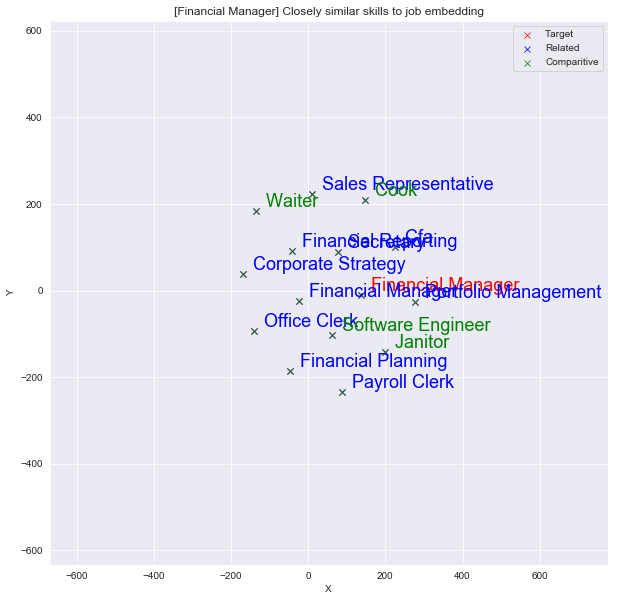

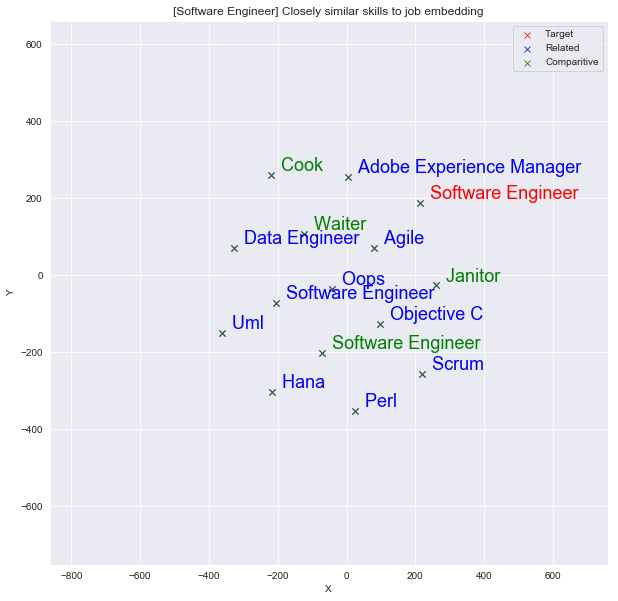

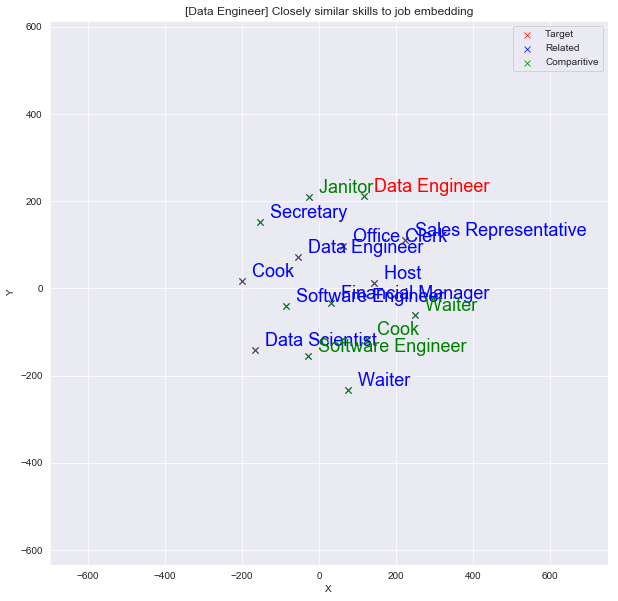

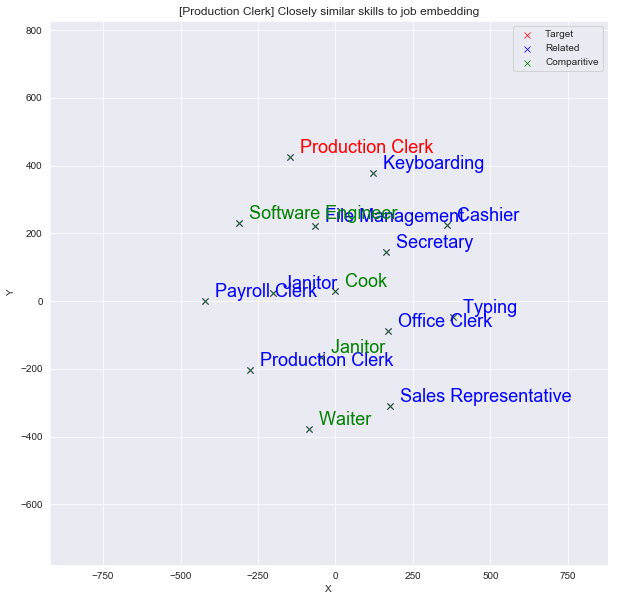

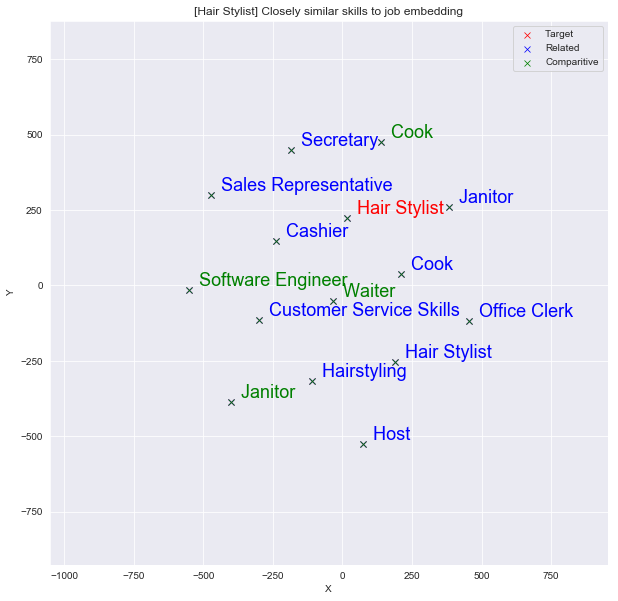

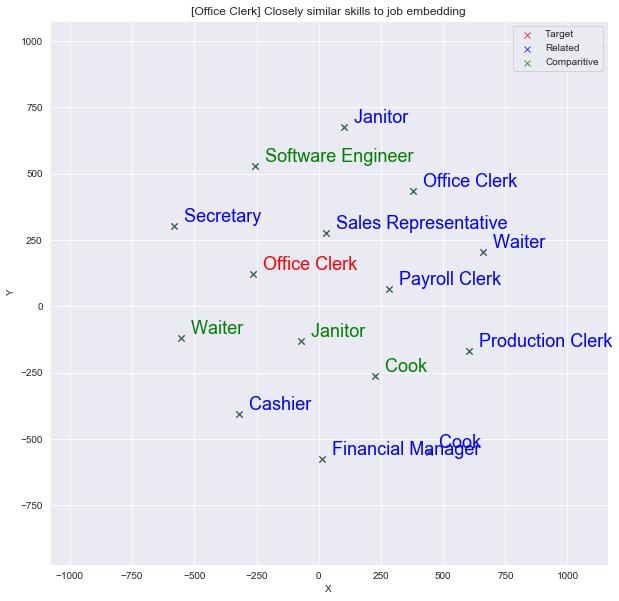

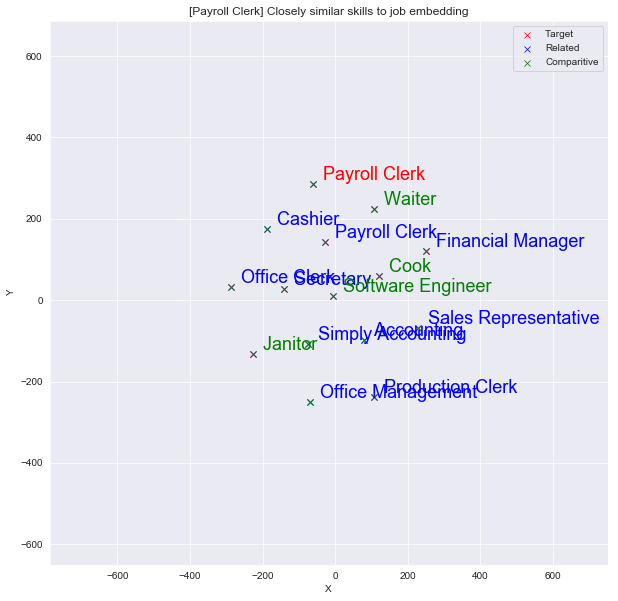

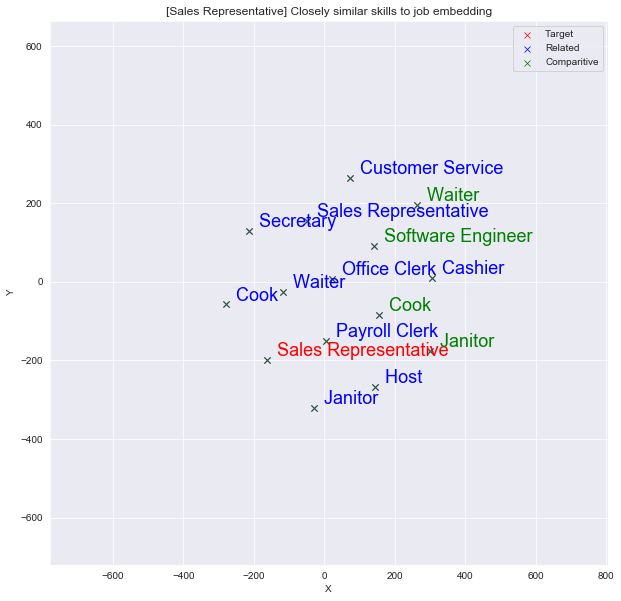

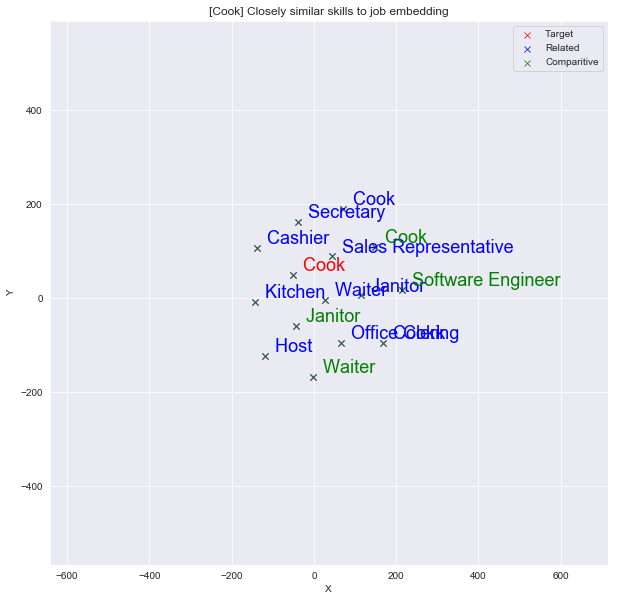

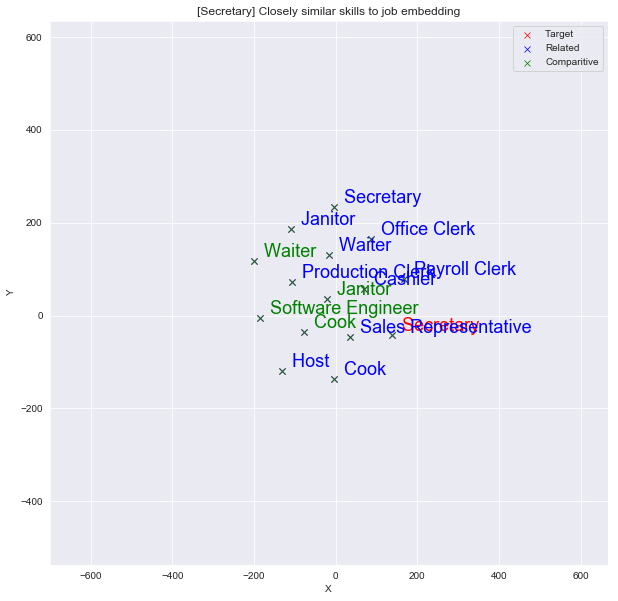

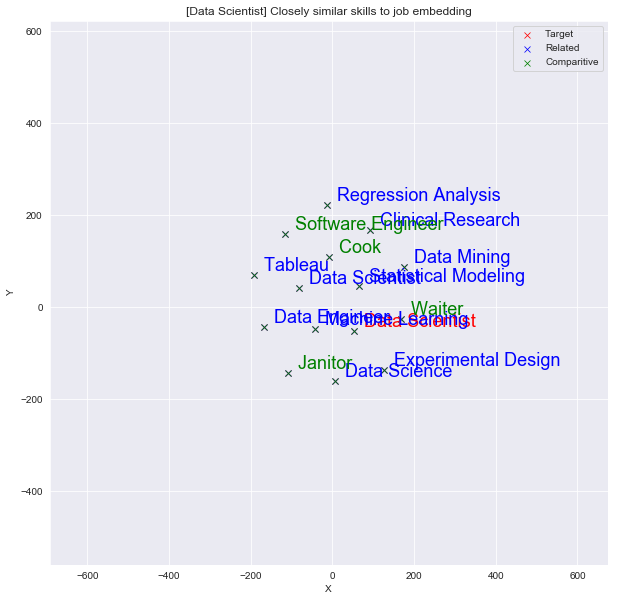

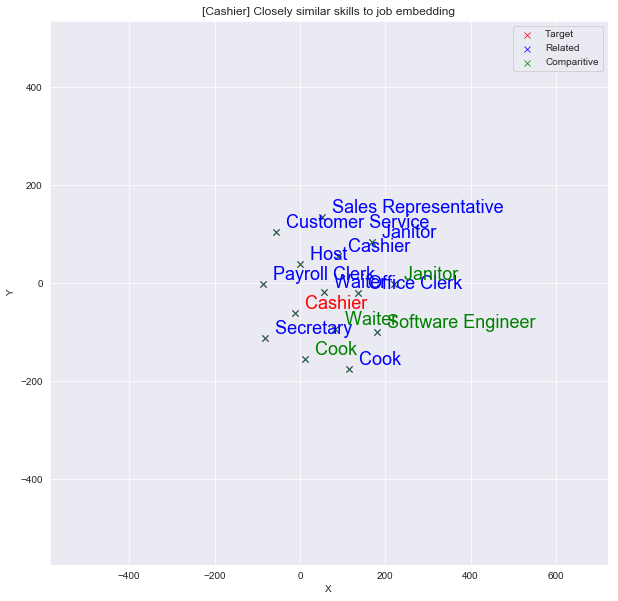

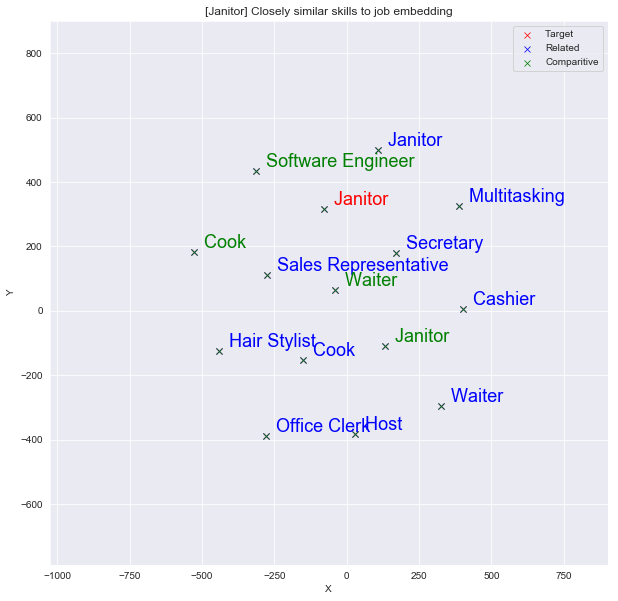

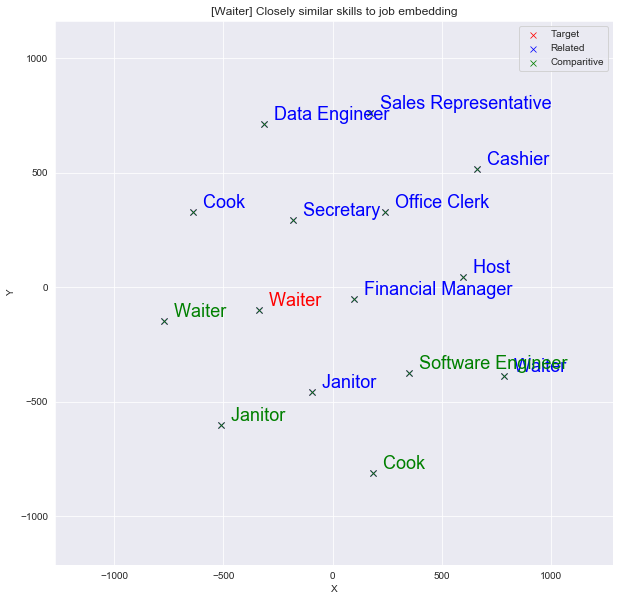

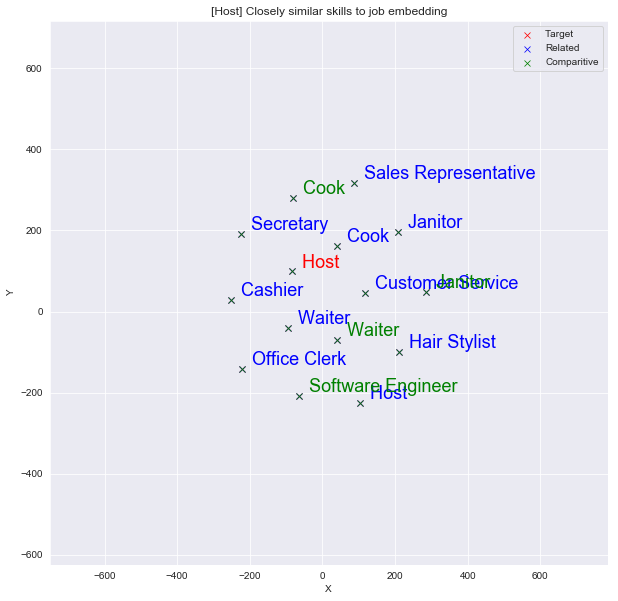

In [148]:
# visualize cluster that has been reduced in dimensionality by t-sne
# the cluster here is pure word embeddings and simply based on closeness
# by embedding similarity
for job_title in unique_jobs:
  df_tsne, Y = tsneconversion(model, job_title, ['cook', 'janitor', 'waiter', 'software engineer'])
  cluster_visualization(df_tsne, job_title, Y, 500, 400, title_fmt='[{}] Closely similar skills to job embedding')

## K Mean Clustering of Skills

In [140]:
from nltk.cluster import KMeansClusterer
import nltk

# Take the word vectors
vec_tor = model.wv.vectors

# Number of cluster
NUM_CLUSTERS=15

unique_jobs = set(job_label)
initial_means = [model[job.lower()] for job in unique_jobs]

/anaconda3/envs/dataworks-forge/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [38]:
# Run K-Mean clustering
kclusterer = KMeansClusterer(
  NUM_CLUSTERS,
  distance=nltk.cluster.util.cosine_distance,
  initial_means = initial_means,
  repeats=1
)
assigned_clusters = kclusterer.cluster(vec_tor, assign_clusters=True)

## PCA and t-SNE reduction for K Mean Visualization

Find tSNE representation

In [168]:
# Finds t-SNE coordinates for 2 dimensions
np.set_printoptions(suppress=True)

Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(vec_tor)

Create a pandas DataFrame of the cluster

In [169]:
# get the vocabulary
vocabulary = list(model.wv.vocab)
# Create a dataframe containing each skill and corresponding cluster number
df_cluster = pd.DataFrame(
  {
    'X': Y[:,0],
    'Y': Y[:,1],
    'skill':vocabulary,
    'cluster':assigned_clusters,
    'point': list(vec_tor)
  }
)

## K Mean Visualization

In [170]:
df_kclust = pd.DataFrame({'X': Y[:,0], 'Y': Y[:,1]})
df_cluster_and_coords = pd.concat([df_kclust, df_cluster], axis = 1)

In [180]:
unique_jobs = set(job_label)
df_jobs_cluster = df_cluster[df_cluster.skill.isin(unique_jobs)]
df_jobs_cluster = df_jobs_cluster.reset_index(drop=True)
df_jobs_cluster

,X,Y,skill,cluster,point
0,-52.843372,59.095760,cashier,1,"[-1.0996443, -0.51475817, -0.25162134, 0.87570..."
1,-12.393484,63.217487,host,0,"[2.1512465, -1.0060283, -1.5396334, 0.75275725..."
2,-6.202511,-87.227119,waiter,11,"[0.9482365, -0.700384, -0.83858603, 1.3885106,..."
3,-58.297646,53.413612,cook,1,"[-0.00085737533, -0.47703195, -0.7641735, 0.95..."
4,31.492088,70.623444,sales representative,6,"[0.3902186, 0.012501404, 0.9845432, 0.47716793..."
5,64.783813,-23.131655,secretary,12,"[-0.16855319, 0.054650184, -0.23166214, 0.7964..."
6,46.887623,31.875082,data engineer,5,"[0.14364381, 0.04432498, 0.124094434, 0.306121..."
7,9.767474,42.790215,data scientist,6,"[-0.09866282, 0.06935915, -0.24251877, 0.43185..."
8,44.060074,-37.584702,software engineer,8,"[0.17400241, -0.0799273, -0.12062386, 0.244436..."
9,41.841476,15.728819,office clerk,4,"[0.004694427, 0.14167088, 0.03473804, 0.254058..."


In [172]:
from nltk.cluster.util import cosine_distance

def get_closest(df_cluster, point, topn=11):
  closeness = df_cluster.copy()
  closeness['distance'] = closeness['point'].apply(lambda p: cosine_distance(p, point))
  closeness = closeness.sort_values('distance')
  return closeness.head(topn)

In [194]:
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_distances

score = silhouette_score(df_cluster.point.tolist(), df_cluster.cluster.tolist(), metric='cosine')
'Silhoutte score is %f' % score

'Silhoutte score is 0.129761'

/anaconda3/envs/dataworks-forge/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


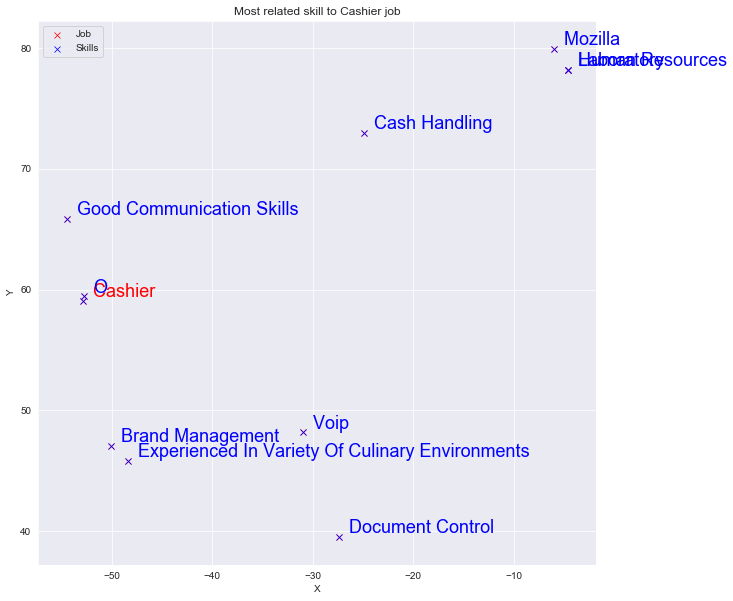

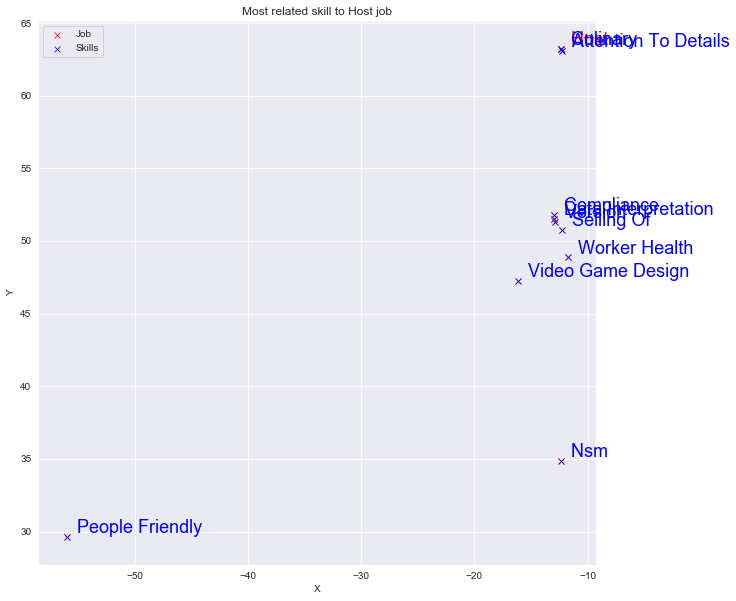

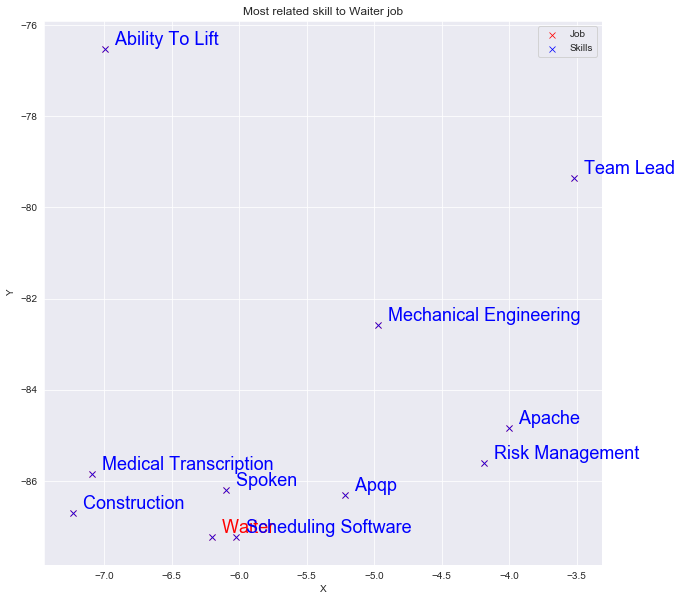

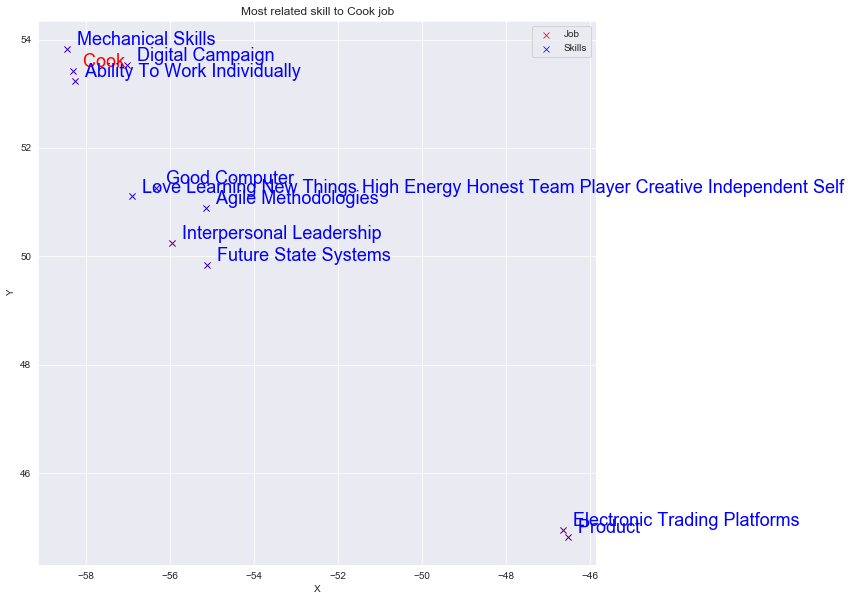

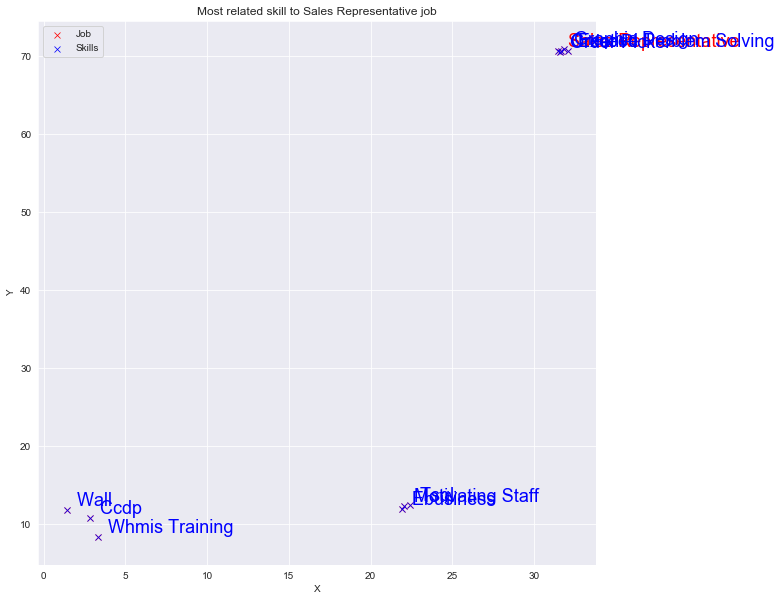

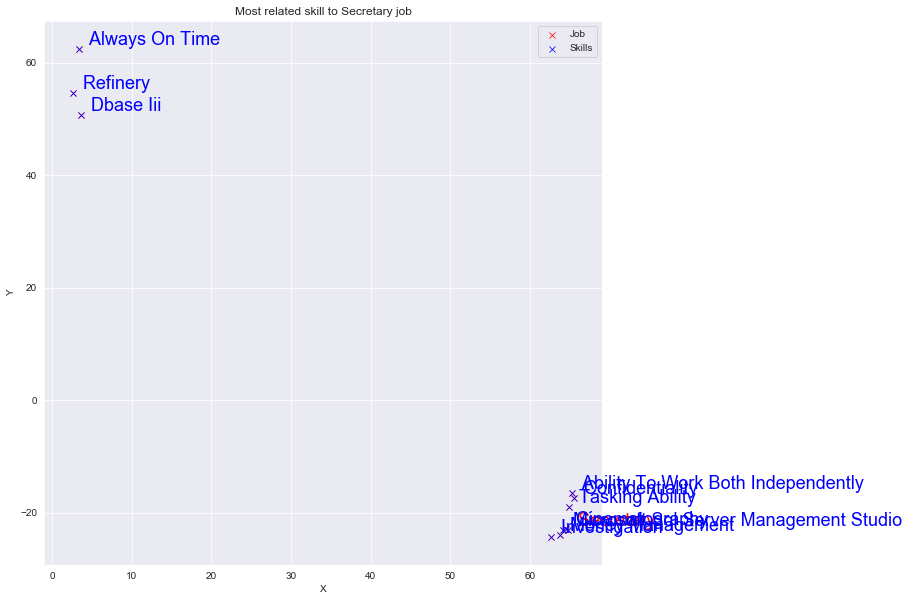

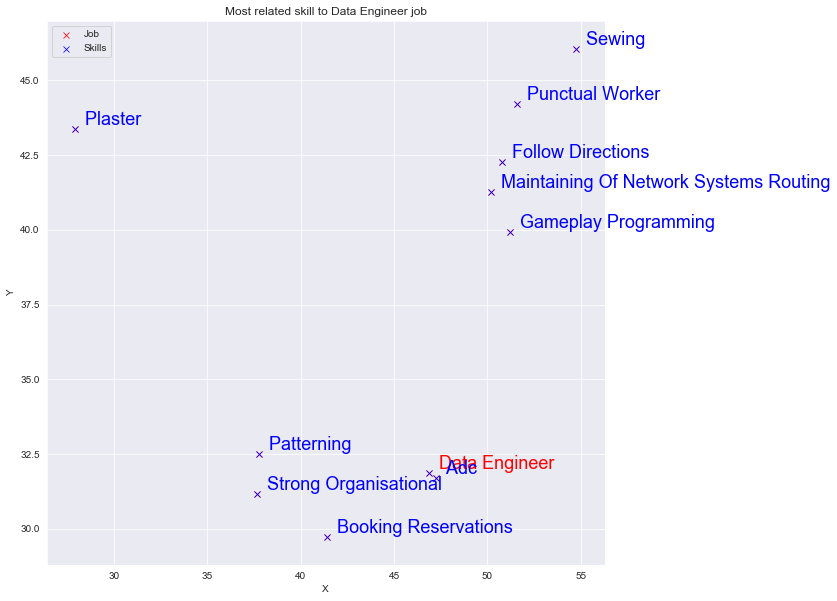

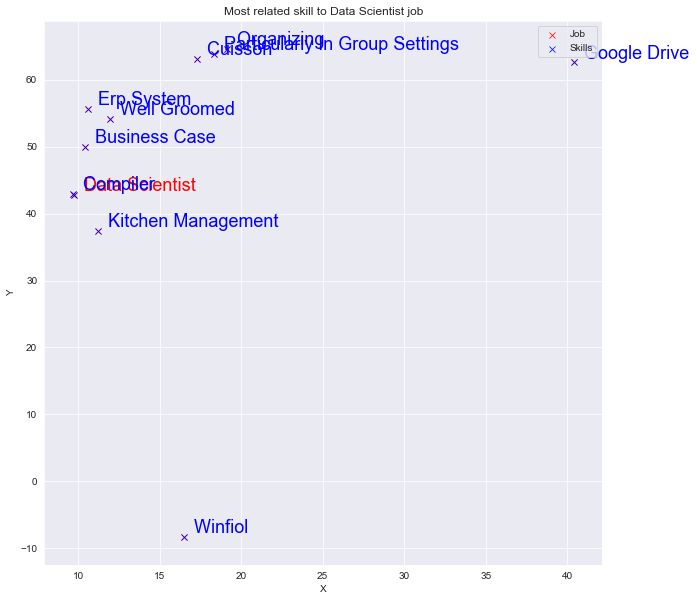

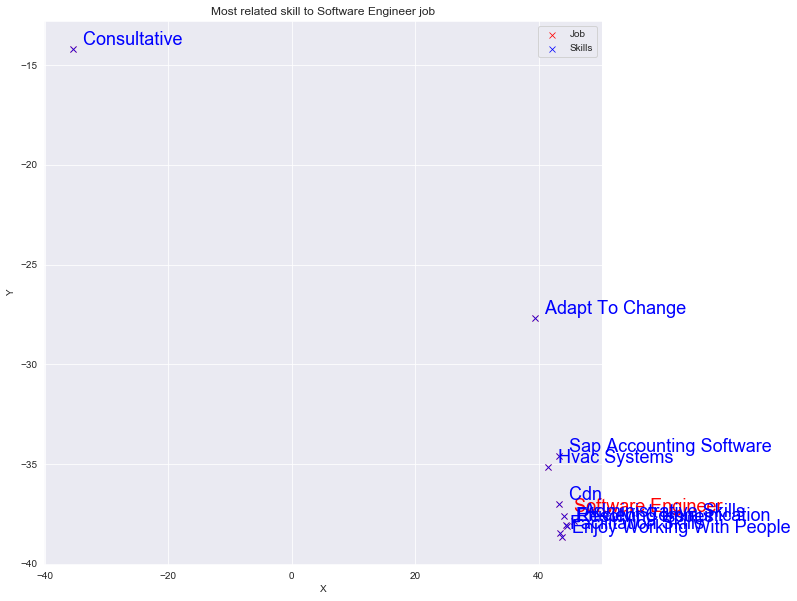

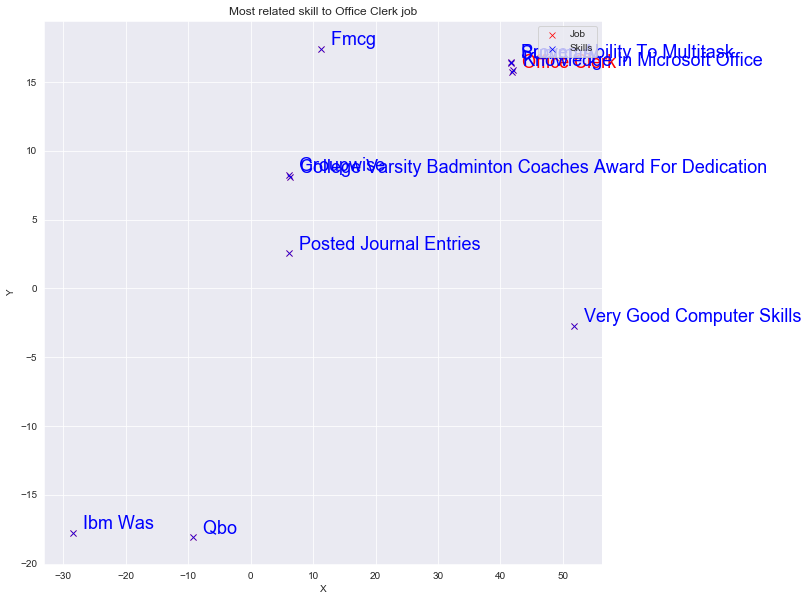

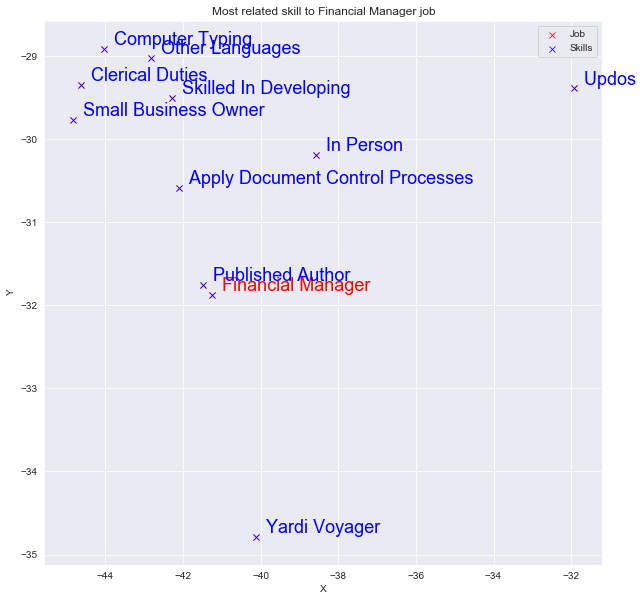

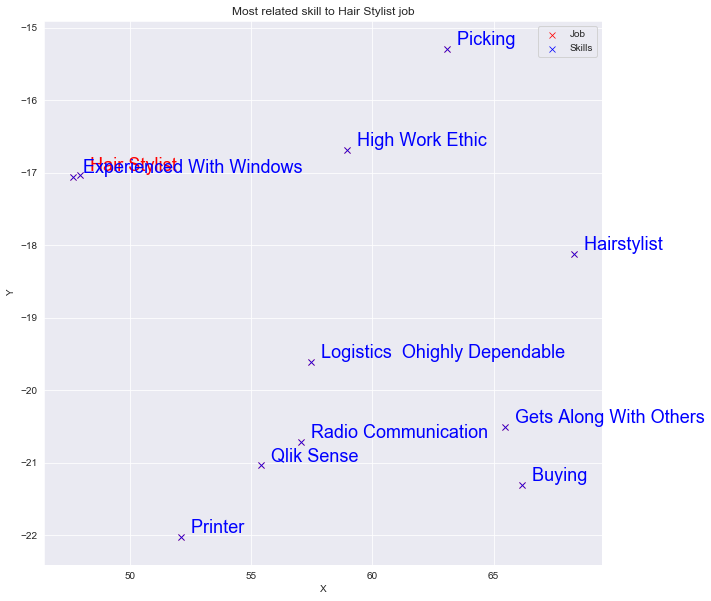

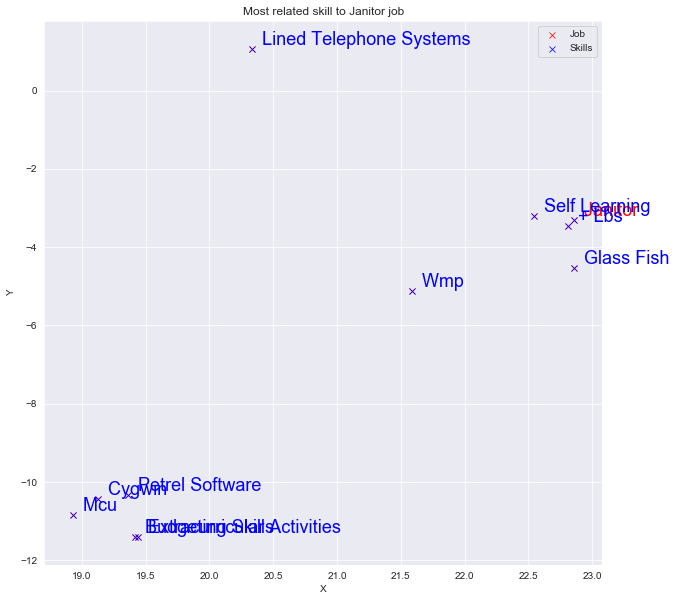

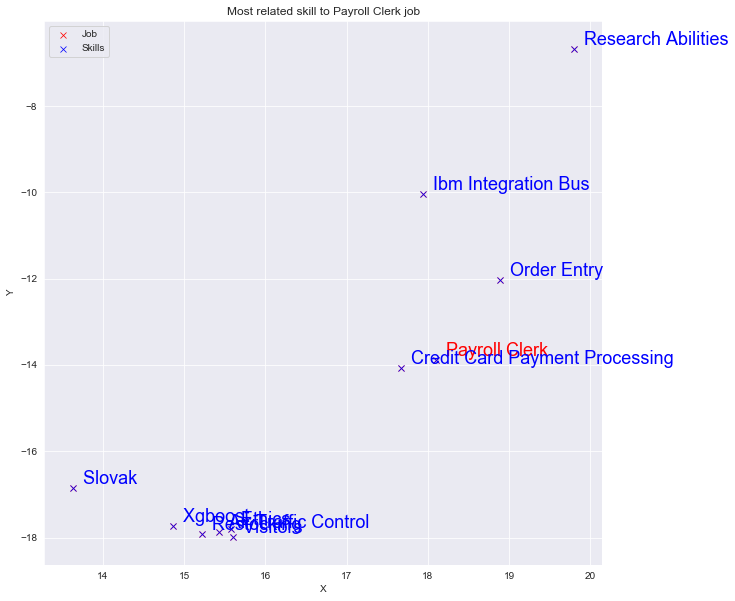

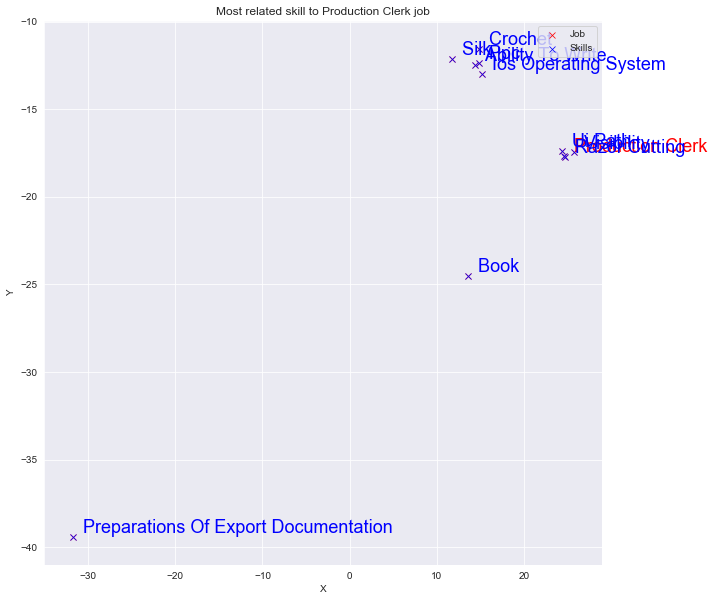

In [191]:
## Plot the cluster of plots with closest skill in the vector space
for idx in range(NUM_CLUSTERS):
  job = df_jobs_cluster.loc[[idx]]
  job.loc[:,"color"] = "red"
  cluster_number = job.cluster.values[0]
  df_job_cluster = df_cluster[df_cluster.cluster == cluster_number]

  N_sample = 10
  color = ["blue"] * N_sample
  df_plot = get_closest(df_cluster, job.point.values[0], topn=N_sample + 1)
  job_name = job.skill.values[0]
  df_plot = df_plot[df_plot.skill != job_name]
  df_plot["color"] = color[:len(df_plot)]
  df_final_plot = pd.concat([job, df_plot])
  labels = ['Job'] + (['Skills'] * len(df_plot))
  df_final_plot['label'] = labels
  df_final_plot = df_final_plot.reset_index(drop=True)

  cluster_visualization(df_final_plot, job_name, Y, 0, 0, title_fmt='Most related skill to {} job')